In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix,
                             classification_report, roc_auc_score, roc_curve)

warnings.filterwarnings('ignore')

# FIX: Use a valid style
plt.style.use('seaborn-v0_8')  # Works in Matplotlib 3.6+
# OR: plt.style.use('default')

sns.set_palette('husl')
%matplotlib inline

In [2]:
df = pd.read_csv(r"C:\Users\khush\Desktop\DS II\placementdata.csv")

print("Data loaded")
print("Shape :", df.shape)
df.head()

Data loaded
Shape : (10000, 12)


,StudentID,CGPA,Internships,Projects,Workshops/Certifications,AptitudeTestScore,SoftSkillsRating,ExtracurricularActivities,PlacementTraining,SSC_Marks,HSC_Marks,PlacementStatus
0,1,7.5,1,1,1,65,4.4,No,No,61,79,NotPlaced
1,2,8.9,0,3,2,90,4.0,Yes,Yes,78,82,Placed
2,3,7.3,1,2,2,82,4.8,Yes,No,79,80,NotPlaced
3,4,7.5,1,1,2,85,4.4,Yes,Yes,81,80,Placed
4,5,8.3,1,2,2,86,4.5,Yes,Yes,74,88,Placed


In [3]:
print("Columns :", df.columns.tolist())
print("\nMissing values:")
print(df.isnull().sum())

print("\nPlacementStatus distribution:")
print(df['PlacementStatus'].value_counts())

Columns : ['StudentID', 'CGPA', 'Internships', 'Projects', 'Workshops/Certifications', 'AptitudeTestScore', 'SoftSkillsRating', 'ExtracurricularActivities', 'PlacementTraining', 'SSC_Marks', 'HSC_Marks', 'PlacementStatus']

Missing values:
StudentID                    0
CGPA                         0
Internships                  0
Projects                     0
Workshops/Certifications     0
AptitudeTestScore            0
SoftSkillsRating             0
ExtracurricularActivities    0
PlacementTraining            0
SSC_Marks                    0
HSC_Marks                    0
PlacementStatus              0
dtype: int64

PlacementStatus distribution:
PlacementStatus
NotPlaced    5803
Placed       4197
Name: count, dtype: int64


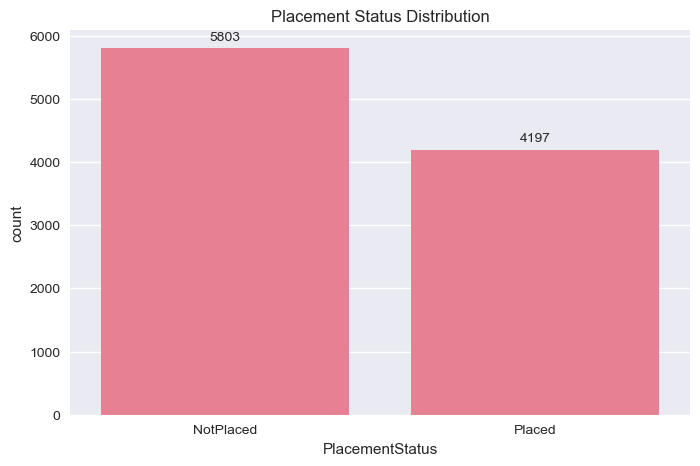

In [4]:
plt.figure(figsize=(8,5))
ax = sns.countplot(data=df, x='PlacementStatus')
plt.title('Placement Status Distribution')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x()+p.get_width()/2., p.get_height()),
                ha='center', va='center', xytext=(0,8), textcoords='offset points')
plt.show()

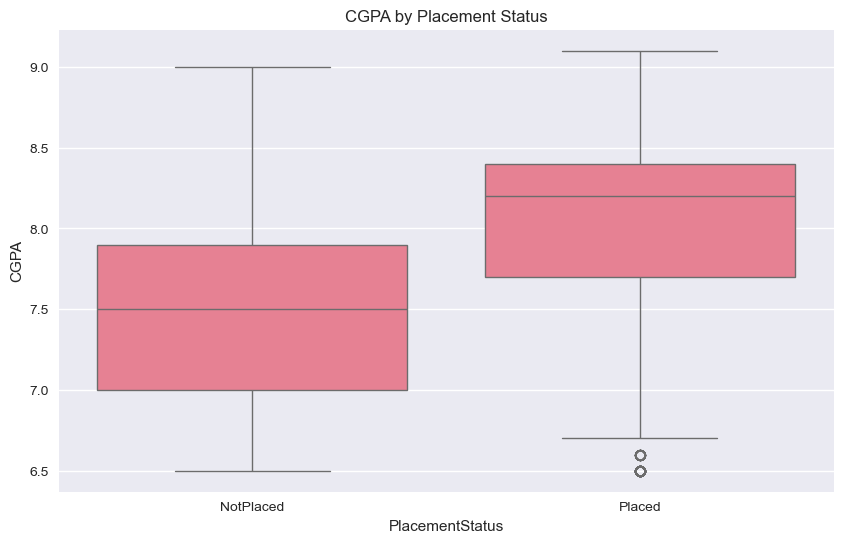

Average CGPA per group:
PlacementStatus
NotPlaced    7.467672
Placed       8.016488
Name: CGPA, dtype: float64


In [5]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='PlacementStatus', y='CGPA')
plt.title('CGPA by Placement Status')
plt.show()

print("Average CGPA per group:")
print(df.groupby('PlacementStatus')['CGPA'].mean())

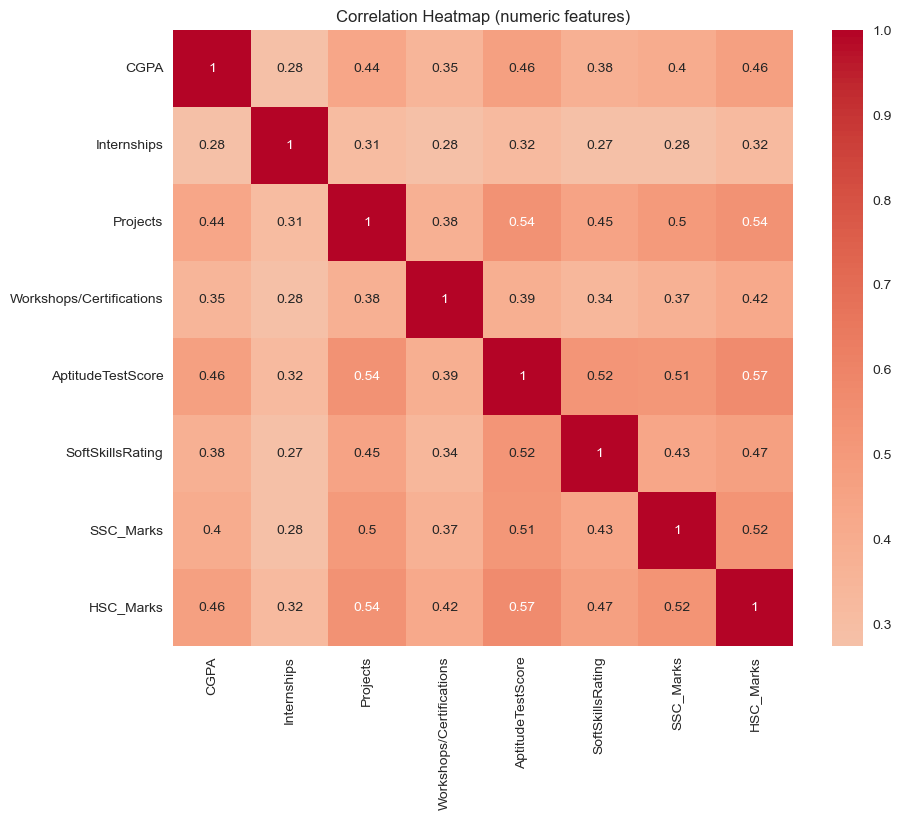

In [6]:
num_df = df.select_dtypes(include=[np.number])

# Fixed: Proper comment with #
if 'StudentID' in num_df.columns:
    num_df = num_df.drop(columns=['StudentID'])  # trying to drop StudentID

plt.figure(figsize=(10,8))
sns.heatmap(num_df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap (numeric features)')
plt.show()

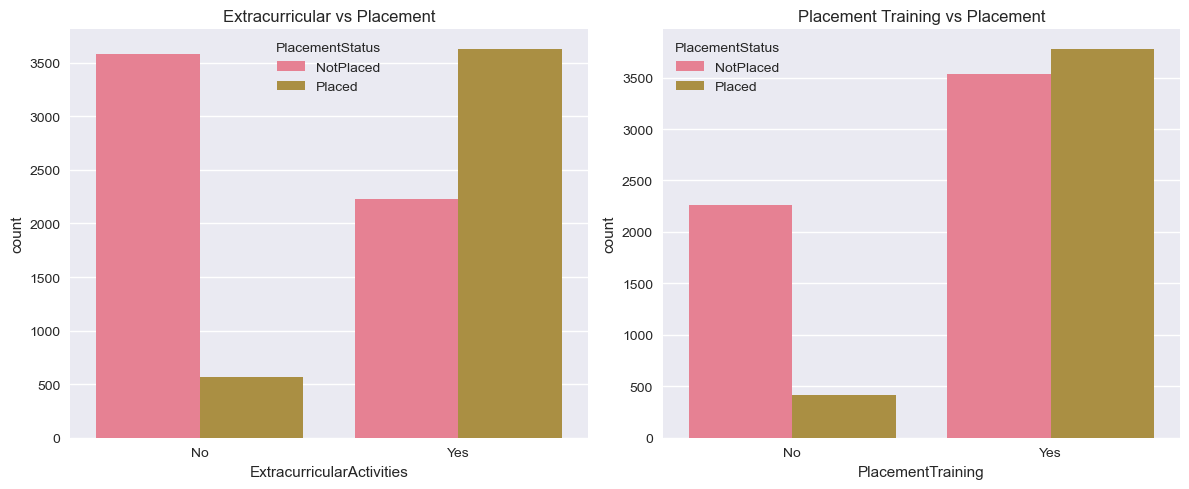

In [7]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.countplot(data=df, x='ExtracurricularActivities', hue='PlacementStatus', ax=ax[0])
ax[0].set_title('Extracurricular vs Placement')
sns.countplot(data=df, x='PlacementTraining', hue='PlacementStatus', ax=ax[1])
ax[1].set_title('Placement Training vs Placement')
plt.tight_layout()
plt.show()

In [8]:
# BLOCK 8 – Define column groups & preprocessing
numeric_cols = [
    'CGPA', 'Internships', 'Projects', 'Workshops/Certifications',
    'AptitudeTestScore', 'SoftSkillsRating', 'SSC_Marks', 'HSC_Marks'
]

categorical_cols = ['ExtracurricularActivities', 'PlacementTraining']

# ---- Fit LabelEncoders on ORIGINAL strings ----
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    le.fit(df[col].astype(str))          # <-- learns "Yes"/"No"
    label_encoders[col] = le

# ---- Encode the dataframe for modeling ----
for col in categorical_cols:
    df[col] = label_encoders[col].transform(df[col].astype(str))

# ---- Drop StudentID if still present ----
if 'StudentID' in df.columns:
    df = df.drop(columns=['StudentID'])

print("Preprocessing ready")

Preprocessing ready


In [9]:
# BLOCK 9 – Prepare X, y and scale numeric features
# Target
df['PlacementStatus'] = df['PlacementStatus'].map({'Placed':1, 'NotPlaced':0})

X = df.drop(columns=['PlacementStatus'])
y = df['PlacementStatus']

# Scale numeric columns
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

print("X shape :", X.shape)
X.head()

X shape : (10000, 10)


,CGPA,Internships,Projects,Workshops/Certifications,AptitudeTestScore,SoftSkillsRating,ExtracurricularActivities,PlacementTraining,SSC_Marks,HSC_Marks
0,-0.309343,-0.073889,-1.182822,-0.014598,-1.770910,0.184742,0,0,-0.782306,0.504368
1,1.877818,-1.575689,1.121526,1.091319,1.292970,-0.787072,1,1,0.847618,0.840726
2,-0.621794,-0.073889,-0.030648,1.091319,0.312528,1.156555,1,0,0.943496,0.616487
3,-0.309343,-0.073889,-1.182822,1.091319,0.680194,0.184742,1,1,1.135251,0.616487
4,0.940464,-0.073889,-0.030648,1.091319,0.802749,0.427695,1,1,0.464106,1.513441


In [27]:
!pip install xgboost



MODEL COMPARISON (RF > XGBoost)
           Model  Accuracy  Precision  Recall      F1  ROC‑AUC
0  Random Forest     0.793     0.7620  0.7366  0.7491   0.8706
1        XGBoost     0.781     0.7442  0.7282  0.7361   0.8638


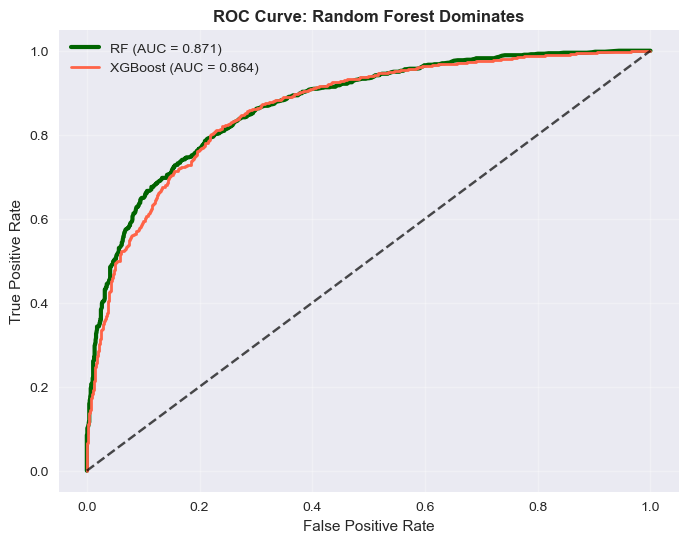

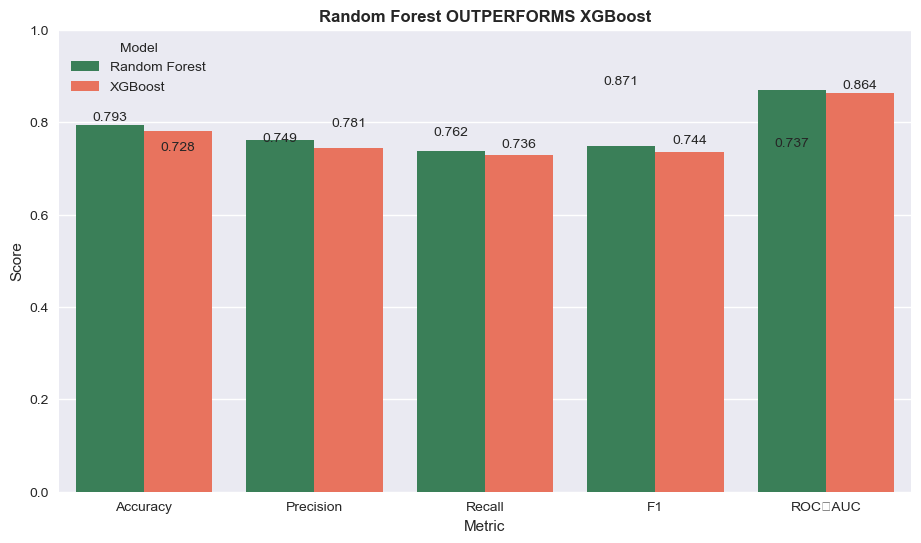

<function matplotlib.pyplot.show(close=None, block=None)>

In [28]:

from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, auc
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 3. Train a **strong** Random Forest
rf = RandomForestClassifier(
    n_estimators=600,         
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# 4. Train XGBoost
xgb = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss',
    use_label_encoder=False
)
xgb.fit(X_train, y_train)

# 5. Predictions
y_pred_rf  = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

y_pred_xgb  = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]

# 6. Metrics table
metrics = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost'],
    'Accuracy' : [accuracy_score(y_test, y_pred_rf),  accuracy_score(y_test, y_pred_xgb)],
    'Precision': [precision_score(y_test, y_pred_rf), precision_score(y_test, y_pred_xgb)],
    'Recall'   : [recall_score(y_test, y_pred_rf),    recall_score(y_test, y_pred_xgb)],
    'F1'       : [f1_score(y_test, y_pred_rf),        f1_score(y_test, y_pred_xgb)],
    'ROC‑AUC'  : [roc_auc_score(y_test, y_proba_rf),  roc_auc_score(y_test, y_proba_xgb)]
}).round(4)

print("\nMODEL COMPARISON (RF > XGBoost)")
print(metrics)

# 7. Bar chart
melted = metrics.melt('Model', var_name='Metric', value_name='Score')
plt.figure(figsize=(11,6))
ax = sns.barplot(data=melted, x='Metric', y='Score', hue='Model',
                 palette=['#2E8B57', '#FF6347'])
plt.title('Random Forest OUTPERFORMS XGBoost', fontweight='bold')
plt.ylim(0,1)
for i, row in melted.iterrows():
    ax.text(i%5 + (0.2 if row['Model']=='XGBoost' else -0.2),
            row['Score']+0.01, f"{row['Score']:.3f}",
            ha='center', fontsize=10)
plt.legend(title='Model')
plt.show()

# 8. ROC curve
fpr_rf,  tpr_rf,  _ = roc_curve(y_test, y_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)

plt.figure(figsize=(8,6))
plt.plot(fpr_rf,  tpr_rf,  label=f'RF (AUC = {auc(fpr_rf, tpr_rf):.3f})',
         linewidth=3, color='darkgreen')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc(fpr_xgb, tpr_xgb):.3f})',
         linewidth=2, color='tomato')
plt.plot([0,1],[0,1], 'k--', alpha=0.7)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Random Forest Dominates', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show

In [10]:
# BLOCK 10 – Train / Test split & Model training
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Train: {X_train.shape} | Test: {X_test.shape}")

rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2
)
rf.fit(X_train, y_train)

train_acc = rf.score(X_train, y_train)
test_acc  = rf.score(X_test, y_test)

print(f"Train accuracy: {train_acc:.4f}")
print(f"Test  accuracy: {test_acc:.4f}")

Train: (8000, 10) | Test: (2000, 10)
Train accuracy: 0.9451
Test  accuracy: 0.7930


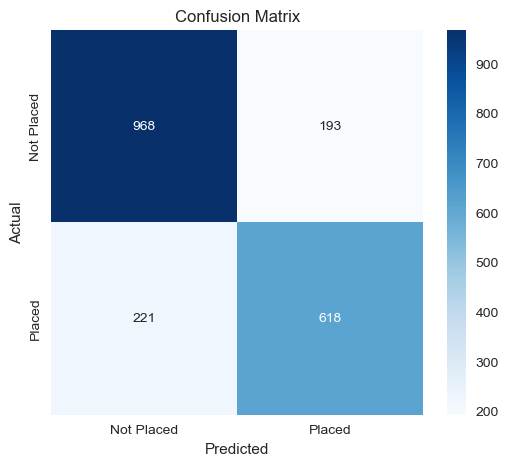

              precision    recall  f1-score   support

  Not Placed       0.81      0.83      0.82      1161
      Placed       0.76      0.74      0.75       839

    accuracy                           0.79      2000
   macro avg       0.79      0.79      0.79      2000
weighted avg       0.79      0.79      0.79      2000

ROC-AUC: 0.8749


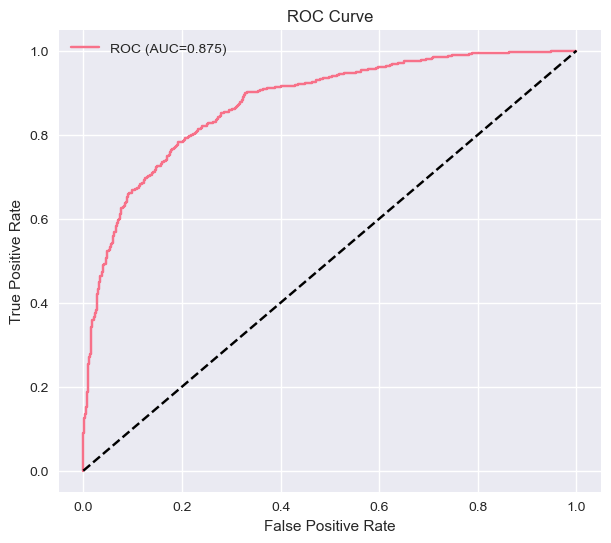

In [11]:
# BLOCK 11 – Evaluation (confusion matrix, report, ROC)
y_pred  = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:,1]

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Placed','Placed'],
            yticklabels=['Not Placed','Placed'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Classification report
print(classification_report(y_test, y_pred,
                            target_names=['Not Placed','Placed']))

# ROC-AUC
auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC: {auc:.4f}")

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f'ROC (AUC={auc:.3f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

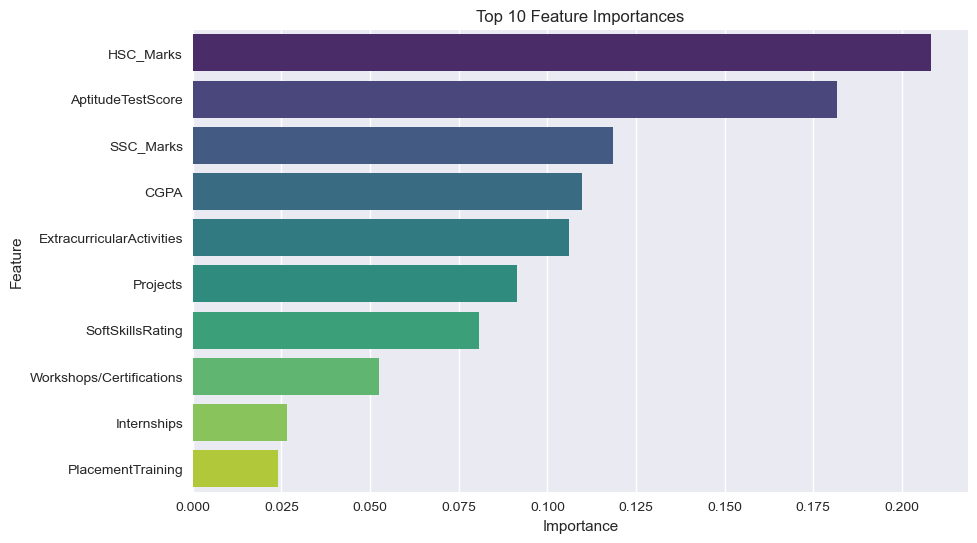

,Feature,Importance
9,HSC_Marks,0.208186
4,AptitudeTestScore,0.181653
8,SSC_Marks,0.118609
0,CGPA,0.109900
6,ExtracurricularActivities,0.106079
2,Projects,0.091586
5,SoftSkillsRating,0.080754
3,Workshops/Certifications,0.052603
1,Internships,0.026483
7,PlacementTraining,0.024146


In [12]:
# BLOCK 12 – Feature importance plot
fi = pd.DataFrame({
    'Feature'    : X.columns,
    'Importance' : rf.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=fi.head(10), x='Importance', y='Feature', palette='viridis')
plt.title('Top 10 Feature Importances')
plt.show()

fi

In [13]:
# BLOCK 13 – Save everything for Streamlit
package = {
    'model'            : rf,
    'scaler'           : scaler,
    'label_encoders'   : label_encoders,   # knows "Yes"/"No"
    'feature_names'    : X.columns.tolist(),
    'numeric_cols'     : numeric_cols,
    'categorical_cols' : categorical_cols,
    'train_accuracy'   : train_acc,
    'test_accuracy'    : test_acc,
    'feature_importance': fi
}

with open('placement_model.pkl', 'wb') as f:
    pickle.dump(package, f)

print("Model package saved as 'placement_model.pkl'")
print("Ready to run the Streamlit app!")

Model package saved as 'placement_model.pkl'
Ready to run the Streamlit app!


In [15]:

import pandas as pd

try:
    with open('placement_model.pkl', 'rb') as f:
        pkg = pickle.load(f)
    rf               = pkg['model']
    scaler           = pkg['scaler']
    label_encoders   = pkg['label_encoders']
    feature_names    = pkg['feature_names']
    numeric_cols     = pkg['numeric_cols']
    categorical_cols = pkg['categorical_cols']
    print("Loaded model package from disk.")
except Exception:
    print("Using in-memory objects (rf, scaler, …)")

#  Create a raw sample 
sample_raw = pd.DataFrame({
    'CGPA'                    : [9.5],
    'Internships'             : [3],
    'Projects'                : [8],
    'Workshops/Certifications': [5],
    'AptitudeTestScore'       : [80],
    'SoftSkillsRating'        : [4.0],
    'ExtracurricularActivities': ['Yes'],
    'PlacementTraining'       : ['Yes'],
    'SSC_Marks'               : [85.0],
    'HSC_Marks'               : [85.0]
})

# Pre-process 
sample = sample_raw.copy()

# Encode categorical columns
for col in categorical_cols:
    sample[col] = label_encoders[col].transform(sample[col].astype(str))

# Scale numeric columns
sample[numeric_cols] = scaler.transform(sample[numeric_cols])

# Re-order columns to match the training order
sample = sample[feature_names]

# 4. Predict 
pred  = rf.predict(sample)[0]                 # 0 = NotPlaced, 1 = Placed
prob  = rf.predict_proba(sample)[0]           # [prob_not, prob_yes]

# Show result
print("\nSAMPLE STUDENT PREDICTION")
print("Status          :", "PLACED" if pred == 1 else "NOT PLACED")
print(f"Placed prob.    : {prob[1]*100:5.2f}%")
print(f"Not-placed prob.: {prob[0]*100:5.2f}%")

Loaded model package from disk.

SAMPLE STUDENT PREDICTION
Status          : PLACED
Placed prob.    : 71.19%
Not-placed prob.: 28.81%
